In [1]:
# Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm as tqdm # for progress bar of epochs

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Loading

In [3]:
# Dataset class
class MNIST_Dataset(Dataset):
    
    def __init__(self, train=True, transform=T.ToTensor()):
        if train:
            self.data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
            self.y = self.data['label']
            self.data = self.data.drop(['label'], axis=1)
        else:
            self.data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
            self.y = None
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = np.array(self.data.iloc[index], dtype=np.float32) # float32 in order to be converted to float with ToTensor() instead of double
        img = img.reshape(28, 28, 1)
        img = img / 255 # Normalization
        if self.transform:
            img = self.transform(img)
            
        if self.y is not None:
            return (img, self.y[index]) # (X, Y)
        else:
            return img # Only X

We'll take 20% of the training data as validation set.

In [4]:
# Splitting X_train into traning and validation sets
full_train_set = MNIST_Dataset(train=True)
val_split = 0.2
len_val_set = int(len(full_train_set)*val_split)
len_train_set = len(full_train_set) - len_val_set 
train_dataset, val_dataset = random_split(full_train_set, (len_train_set, len_val_set))

# Test set
test_dataset = MNIST_Dataset(train=False)

# Details
print(f'Total no. of train imgs: {len(train_dataset)}')
print(f"Total no. of validation imgs: {len(val_dataset)}")
print(f"Total no. of test imgs: {len(test_dataset)}")

Total no. of train imgs: 33600
Total no. of validation imgs: 8400
Total no. of test imgs: 28000


## Visualization

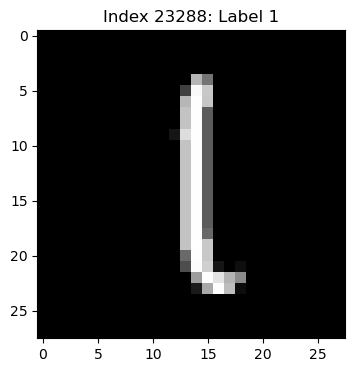

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
idx = np.random.choice(np.arange(len(train_dataset)))
img, label = train_dataset[idx]
ax.set(title=f'Index {idx}: Label {label}')
ax.imshow(img.squeeze(),cmap = 'gray');

## CNN

In [6]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.2)  # Regularization
        self.maxpool2d = nn.MaxPool2d(kernel_size=2) # Dimensionality reduction
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(self.maxpool2d(self.conv1(x)))
        x = F.relu(self.maxpool2d(self.conv2_drop(self.conv2(x))))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        
        return F.log_softmax(x, dim=1)
    
# CNN instance
cnn = CNN()
cnn.to(device)
cnn

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.2, inplace=False)
  (maxpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Model Summary
`torchsummary` package. To plot the model summary

In [7]:
%%capture
!pip install torchsummary

In [8]:
from torchsummary import summary
summary(cnn, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         Dropout2d-4             [-1, 20, 8, 8]               0
         MaxPool2d-5             [-1, 20, 4, 4]               0
            Linear-6                   [-1, 50]          16,050
            Linear-7                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.08
Estimated Total Size (MB): 0.16
----------------------------------------------------------------


## DataLoader

In [9]:
# Creating batches generator
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# First Batch
dataiter = iter(train_loader)
imgs, labels = next(dataiter)

print('Shape of loading one batch: {}'.format(imgs.shape))
print('Total no. of batches created in Train loader: {}'.format(len(train_loader)))
print('Total no. of batches created in Valid loader: {}'.format(len(val_loader)))

Shape of loading one batch: torch.Size([64, 1, 28, 28])
Total no. of batches created in Train loader: 525
Total no. of batches created in Valid loader: 132


In [10]:
# Optimize parameters
criterion = nn.NLLLoss()
# log_softmax in output activation + nn.NLLLoss() =  nn.CrossEntropyLoss() !
optimizer = optim.AdamW(cnn.parameters(), lr=0.01)

## Training

For training we use the negative log likelihood loss `NLLLoss()`. 

In our CNN, we return the log_softmax of the last layer, which actually gives log-probabilities output. Then applying `NLLLoss()` to this output is the same as using the `CrossEntropyLoss()` (if we want to use `CrossEntropyLoss()`, we can return directly the last layer without the `log_softmax()`.

In [11]:
# Fonction used in order to compute the accuracy for each batch
def multiclass_accuracy(y_pred, y_true):
    top_pred, y_pred_class = y_pred.topk(1, dim = 1)
    equals = (y_pred_class == y_true.view(*y_pred_class.shape))
    return torch.mean(equals.type(torch.FloatTensor))

In [12]:
# Training loop

# Number of epochs
epochs = 15

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for i in tqdm(range(epochs), 'Epochs'):

    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # Train on each batch
    cnn.train()
    for X_batch, label_batch in train_loader:
        X_batch, label_batch = X_batch.to(device), label_batch.to(device)
        logpreds = cnn(X_batch)

        loss = criterion(logpreds, label_batch)
        optimizer.zero_grad()
        loss.backward() # dw, db
        optimizer.step() # w = w - lr*dw
        train_loss += loss.item()

        preds = torch.exp(logpreds)
        train_acc += multiclass_accuracy(preds, label_batch)

    # Evaluation for each batch
    cnn.eval() # Dropout, Batch Norm
    for X_batch, label_batch in val_loader:
        X_batch, label_batch = X_batch.to(device), label_batch.to(device)
        logpreds = cnn(X_batch)

        loss = criterion(logpreds, label_batch)
        val_loss += loss.item()

        preds = torch.exp(logpreds)
        val_acc += multiclass_accuracy(preds, label_batch)

    # Aggregate the loss for the current epoch
    avg_train_loss = train_loss/len(train_loader)
    avg_train_acc = train_acc/len(train_loader)
    avg_val_loss = val_loss/len(val_loader)
    avg_val_acc = val_acc/len(val_loader)

    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

Epochs:   0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
# Plot train and validation losses
fig = go.Figure()
train_losses = pd.Series(train_losses)
val_losses = pd.Series(val_losses)
fig.add_trace(go.Scatter(x=train_losses.index, y=train_losses, name="Train Loss"))
fig.add_trace(go.Scatter(x=val_losses.index, y=val_losses, name="Val Loss"))
fig.update_layout(title=dict(text="Train and Validation Loss", x=0.5), xaxis=dict(title="Epochs"), yaxis=dict(title="Loss"))

In [14]:
# Plot train and validation accuracy
fig = go.Figure()
train_accs = pd.Series(train_accs)
val_accs = pd.Series(val_accs)
fig.add_trace(go.Scatter(x=train_accs.index, y=train_accs, name="Train Accuracy"))
fig.add_trace(go.Scatter(x=val_accs.index, y=val_accs, name="Val Accuracy"))
fig.update_layout(title=dict(text="Train and Validation Accuracy", x=0.5), xaxis=dict(title="Epochs"), yaxis=dict(title="Accuracy (%)"))

## Test set predictions

In [15]:
# Test set predictions
cnn.eval() # Dropout, Batch Norm
test = next(iter(DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False))).to(device).detach()
logpreds = cnn(test)
preds = torch.exp(logpreds) # Probabilities 
_, y_pred = preds.topk(1, dim = 1)
y_pred = pd.DataFrame({'ImageId': np.arange(1, len(test_dataset)+1), 'Label': y_pred.cpu().numpy().squeeze()})
y_pred.to_csv('submission.csv', index=False)